### THE WAY TRANSFER LEARNING(freezing all layers last few and training last few layers) WORKS IS BECAUSE THE FROZEN LAYERS LEARNS THE REUSABLE THINGS LIKE IDENTIFYING SHAPES EDGES , WHILE THE ANN PART OF IT IS RESPOSNSIBLE FOR ASSOCIATING COMBINATIONS OF SHAPES AND EDGES WITH OBJECTS (WHICH CAN BE DIFFERENT FOR DIFFERENT USE CASES) THUS THEIR ASSOCIATION TRAINING WITH OBJECTS IS EFFECTIVE

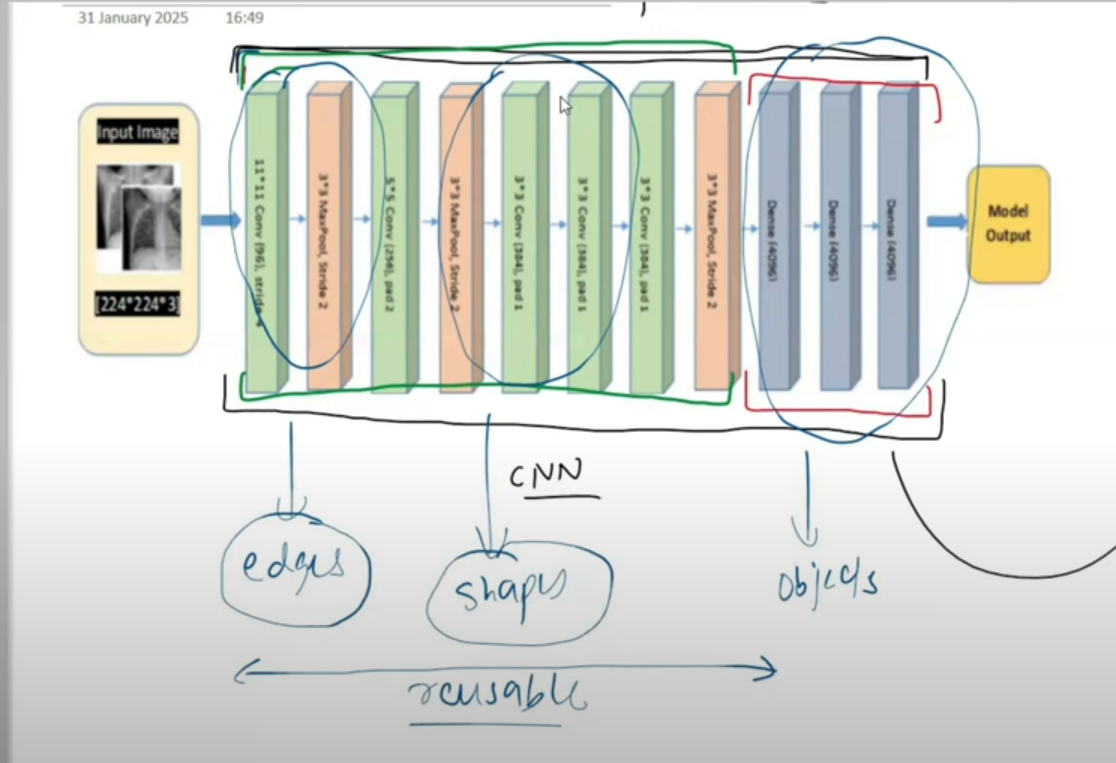

In [1]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [22]:
df = pd.read_csv(r"/content/sample_data/fashion-mnist_train.csv")

In [23]:
df = df.fillna(0)

In [24]:
x=df.drop("label",axis=1)
y=df["label"]

In [25]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

### DATA PREP REQUIREMENTS BEFORE USING VGG 16

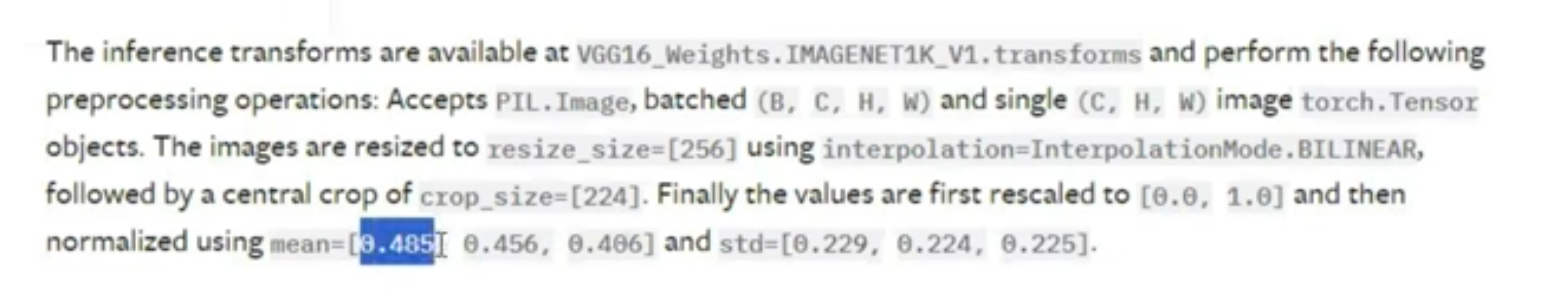

### NOW WILL PERFORM DATA PREPARATION STEPS FOR VGG 16

In [26]:
from torchvision.transforms import transforms
from PIL import Image
import numpy as np

In [28]:

custom_transform =transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])]
)

In [39]:
class customdata(Dataset):
    def __init__(self,x,y,transform):
        super().__init__()
        self.x=x.values
        self.y=y.values
        self.transform=transform
    def __len__(self):
        return len(self.x)
    def __getitem__(self,index):
        # resize to (28,28)
        x= self.x[index].reshape(28,28)

        # change datatype to uint8
        x= x.astype(np.uint8)

        # add channels (optional)
        x= np.stack([x]*3,axis=-1) # axis=-1 transforms (H,W,C) to (C,W,H)
        # covert to pil image
        x= Image.fromarray(x)
        # apply transformations
        x= self.transform(x)
        # apply label
        y= torch.tensor(self.y[index],dtype=torch.long)
        return x,y

In [40]:
train_data = customdata(X_train,y_train,custom_transform)
test_data = customdata(X_test,y_test,custom_transform)


In [61]:
train_dataloader = DataLoader(train_data,batch_size=256,shuffle=True)
test_dataloader = DataLoader(test_data,batch_size=256,shuffle=True)

In [62]:
for x,y in train_dataloader:
    print(x.shape,y.shape)
    break

torch.Size([256, 3, 224, 224]) torch.Size([256])


## FETCHING PRETRAINED VGG MODEL

In [63]:
import torchvision.models as model

vgg16 = model.vgg16(pretrained=True)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [64]:
vgg16.features

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (17): Conv2d(256, 512, kernel_si

In [65]:
vgg16.classifier

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=1000, bias=True)
)

### IN FEATURE TRAINING SETTING WEIGHT UPDATES OF FEATUES TO FALSE

In [66]:
for param in vgg16.features.parameters():
  param.requires_grad = False

## we can define a custom classifer layer by using vgg16.classifier = nn.Sequential () skipping for now

In [67]:
vgg16=vgg16.to(device)

In [68]:
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(vgg16.classifier.parameters(),lr=0.05)

In [69]:
for i in range(5):
  net_loss=0
  for x,y in train_dataloader:
    x=x.to(device)
    y=y.to(device)
    y_pred = vgg16(x)
    l = loss(y_pred,y)
    optimizer.zero_grad()
    l.backward()
    optimizer.step()
    net_loss+=l.item()

  print(f"Epoch {i} Loss {net_loss/32}")

Epoch 0 Loss 5227.444848682731
Epoch 1 Loss 100.85849730297923
Epoch 2 Loss 42.20184978470206
Epoch 3 Loss 22.043814800679684
Epoch 4 Loss 24.93122161179781


In [70]:
vgg16.eval()
correct=0
total=0
with torch.no_grad():
  for x,y in test_dataloader:

    x=x.to(device)
    y=y.to(device)
    y_pred = vgg16(x)
    correct+=torch.sum(torch.argmax(y_pred,dim=1)==y).item()
    total+=y.shape[0]
print(f"Accuracy {correct*100/total}%")


Accuracy 23.275%
